In [12]:
using ForwardDiff
using Plots

In [237]:
# Dubins car parallel park

n = 3 # number of states
m = 2 # number of controls

# initial and goal states
x0 = [0.;0.;0.]
xf = [0.;1.;0.]

# costs
Q = 0.001*eye(n)
Qf = 100.0*eye(n)
R = 0.001*eye(m)

# simulation
tf = 5.0
dt = 0.01

0.01

In [238]:
# Dynamics (RK4 discretization)
function fc(x,u)
    return [u[1]*cos(x[3]); u[1]*sin(x[3]); u[2]]
end

function f(x,u,dt)
    # Runge-Kutta 4
    k1 = dt*fc(x,u)
    k2 = dt*fc(x + k1/2,u)
    k3 = dt*fc(x + k2/2,u)
    k4 = dt*fc(x + k3, u)
    return x + (k1 + 2*k2 + 2*k3 + k4)/6
end

function fc_aug(S)
    return [S[4]*cos(S[3]); S[4]*sin(S[3]); S[5]; 0.0; 0.0; 0.0] 
    
end

function f_aug(S)
    k1 = S[end]*fc_aug(S)
    k2 = S[end]*fc_aug(S + k1/2)
    k3 = S[end]*fc_aug(S + k2/2)
    k4 = S[end]*fc_aug(S + k3)
    return S + (k1 + 2*k2 + 2*k3 + k4)/6
end

F = S-> ForwardDiff.jacobian(f_aug, S)

(::#149) (generic function with 1 method)

In [239]:
#iLQR
function rollout(x0,U,f,dt,tf)
    N = convert(Int64,floor(tf/dt))
    X = zeros(size(x0,1),N)
    X[:,1] = x0
    for k = 1:N-1
      X[:,k+1] = f(X[:,k],U[:,k],dt)
    end
    return X
end

function cost(X,U,Q,R,Qf,xf)
    N = size(X,2)
    J = 0.0
    for k = 1:N-1
      J += 0.5*(X[:,k] - xf)'*Q*(X[:,k] - xf) + 0.5*U[:,k]'*R*U[:,k]
    end
    J += 0.5*(X[:,N] - xf)'*Qf*(X[:,N] - xf)
    return J
end

function backwardpass(X,U,F,Q,R,Qf,xf)
    n, N = size(X)
    m = size(U,1)
    
    S = zeros(n,n,N)
    s = zeros(n,N)
    
    Qx = zeros(n,1,N)
    Qu = zeros(m,1,N)
    Qxx = zeros(n,n,N)
    Quu = zeros(m,m,N)
    Qux = zeros(m,n,N)
    
    K = zeros(m,n,N-1)
    l = zeros(m,N-1)
    
    S[:,:,N] = Qf
    s[:,N] = Qf*(X[:,N] - xf)
    v1 = 0.0
    v2 = 0.0

    mu = 0.0
    k = N-1
    
    while k >= 1
        q = Q*(X[:,k] - xf)
        r = R*(U[:,k])
        F_aug = F([X[:,k];U[:,k];dt])
        fx = F_aug[1:size(X,1),1:size(X,1)]
        fu = F_aug[1:size(X,1),size(X,1)+1:size(X,1)+size(U,1)]
        
        Qx[:,:,k] = q + fx'*s[:,k+1]
        Qu[:,:,k] = r + fu'*s[:,k+1]
        Qxx[:,:,k] = Q + fx'*S[:,:,k+1]*fx
        Quu[:,:,k] = R + fu'*(S[:,:,k+1] + mu*eye(n))*fu
        Qux[:,:,k] = fu'*(S[:,:,k+1] + mu*eye(n))*fx

        # regularization        
        if any(x->x < 0.0, (eigvals(Quu[:,:,k])))
            mu = mu + 1.0;
            k = N-1;
            println("regularized")
        end
        
        K[:,:,k] = Quu[:,:,k]\Qux[:,:,k]
        l[:,k] = Quu[:,:,k]\Qu[:,:,k]
        s[:,k] = (Qx[:,:,k]' - Qu[:,:,k]'*K[:,:,k] + l[:,k]'*Quu[:,:,k]*K[:,:,k] - l[:,k]'*Qux[:,:,k])'
        S[:,:,k] = Qxx[:,:,k] + K[:,:,k]'*Quu[:,:,k]*K[:,:,k] - K[:,:,k]'*Qux[:,:,k] - Qux[:,:,k]'*K[:,:,k]

        # terms for line search
        v1 += l[:,k]'*Qu[:,:,k]
        v2 += l[:,k]'*Quu[:,:,k]*l[:,k]
        
        k = k - 1;
    end
    return K, l, v1, v2
end

function forwardpass(X,U,f,J,K,l,v1,v2,c1=0.0,c2=1.0)
    N = size(X,2)
    m = size(U,1)
    X_prev = copy(X)
    J_prev = copy(J)
    U_ = zeros(m,N-1)
    J = Inf
    dV = 0.0
    dJ = 0.0
    z = 0.0
    
    alpha = 1.0

    while J > J_prev || z < c1 || z > c2 
        for k = 1:N-1
          U_[:,k] = U[:,k] - K[:,:,k]*(X[:,k] - X_prev[:,k]) - alpha*l[:,k]
          X[:,k+1] = f(X[:,k],U_[:,k],dt);
        end

        J = cost(X,U_,Q,R,Qf,xf)
        
        dV = alpha*v1 + (alpha^2)*v2/2.0
        dJ = J_prev - J
        z = dJ/dV[1]

        alpha = alpha/2.0;
    end

    println("New cost: $J")
    println("- Expected improvement: $(dV[1])")
    println("- Actual improvement: $(dJ)")
    println("- (z = $z)\n")
    
    return X, U_, J
end

function solve(x0,m,f,F,Q,R,Qf,xf,dt,tf,iterations=100,eps=1e-5;control_init="random")
    N = convert(Int64,floor(tf/dt))
    X = zeros(size(x0,1),N)
    
    if control_init == "random"
        U = 10.0*rand(m,N-1)
    else
        U = zeros(m,N-1)
    end
        
    X = rollout(x0,U,f,dt,tf)
    J_prev = cost(X,U,Q,R,Qf,xf)
    println("Initial Cost: $J_prev\n")
    
    for i = 1:iterations
        println("*** Iteration: $i ***")
        K, l, v1, v2 = backwardpass(X,U,F,Q,R,Qf,xf)
        X, U, J = forwardpass(X,U,f,J_prev,K,l,v1,v2)

        if abs(J-J_prev) < eps
          println("-----SOLVED-----")
          println("eps criteria met at iteration: $i")
          break
        end
        J_prev = copy(J)
    end
    
    return X, U
end

solve (generic function with 4 methods)

In [242]:
X, U = @time solve(x0,m,f,F,Q,R,Qf,xf,dt,tf,control_init="random");

Initial Cost: 33369.19933504121

*** Iteration: 1 ***
New cost: 6524.06771183919
- Expected improvement: 99923.60093067298
- Actual improvement: 26845.131623202018
- (z = 0.2686565673491608)

*** Iteration: 2 ***
New cost: 1539.9357658295035
- Expected improvement: 18627.488204091598
- Actual improvement: 4984.131946009687
- (z = 0.26756865399141166)

*** Iteration: 3 ***
New cost: 1090.8316056660283
- Expected improvement: 1764.1826572239238
- Actual improvement: 449.10416016347517
- (z = 0.2545678353227748)

*** Iteration: 4 ***
New cost: 292.768619559848
- Expected improvement: 3040.7000655547045
- Actual improvement: 798.0629861061802
- (z = 0.26246027852161485)

*** Iteration: 5 ***
New cost: 235.97243171030772
- Expected improvement: 70.0426977040336
- Actual improvement: 56.796187849540274
- (z = 0.8108795022363839)

*** Iteration: 6 ***
New cost: 171.57265829513383
- Expected improvement: 119.79346176461854
- Actual improvement: 64.39977341517388
- (z = 0.5375900526333617)

***

New cost: 0.31183856007305155
- Expected improvement: 0.0012657764065537535
- Actual improvement: 0.00023257537003806839
- (z = 0.18374127439401886)

*** Iteration: 51 ***
New cost: 0.31159441051848485
- Expected improvement: 0.001230618974043177
- Actual improvement: 0.0002441495545666972
- (z = 0.19839573394886648)

*** Iteration: 52 ***
New cost: 0.311336992915072
- Expected improvement: 0.0011975480815822667
- Actual improvement: 0.00025741760341285724
- (z = 0.21495387731968382)

*** Iteration: 53 ***
New cost: 0.3110680201434903
- Expected improvement: 0.001169192316238128
- Actual improvement: 0.0002689727715817214
- (z = 0.23005006776570366)

*** Iteration: 54 ***
New cost: 0.31078675501265884
- Expected improvement: 0.0011407841909096602
- Actual improvement: 0.0002812651308314318
- (z = 0.2465541976060794)

*** Iteration: 55 ***
New cost: 0.3104947897175886
- Expected improvement: 0.0011164270591041065
- Actual improvement: 0.00029196529507025115
- (z = 0.26151757312702817)



New cost: 0.30211352883317116
- Expected improvement: 5.3276708690142035e-5
- Actual improvement: 2.76270574188775e-5
- (z = 0.5185578857649933)

*** Iteration: 100 ***
New cost: 0.3020885370411628
- Expected improvement: 4.803848755603857e-5
- Actual improvement: 2.4991792008377534e-5
- (z = 0.520245188386161)

 11.750498 seconds (21.08 M allocations: 1.824 GiB, 20.05% gc time)


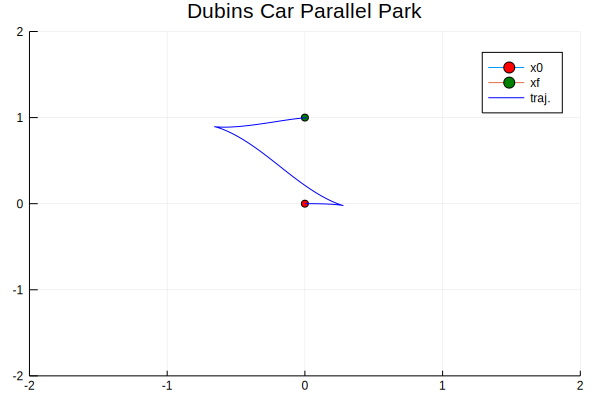

In [243]:
plot((x0[1],x0[2]),marker=(:circle,"red"),label="x0")
plot!((xf[1],xf[2]),marker=(:circle,"green"),label="xf")
plot!(X[1,:],X[2,:],title="Dubins Car Parallel Park",label="traj.",color="blue",xlim=(-2,2),ylim=(-2,2))

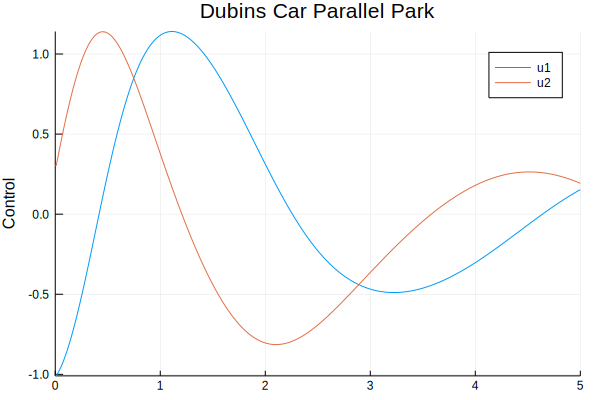

In [231]:
W = plot(linspace(0,tf,size(X,2)),[U[1,1] U[1,:]']',title="Dubins Car Parallel Park",label="u1")
W = plot!(linspace(0,tf,size(X,2)),[U[2,1] U[2,:]']',ylabel="Control",label="u2")